In [3]:
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import imutils
import pathlib
import time
import PIL as pil
import shutil
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import gc
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import joblib

import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Conv2D, DepthwiseConv2D, Add, Activation, BatchNormalization, ReLU

In [4]:
import tensorflow as tf
from tensorflow.keras import layers
class GAM(tf.keras.layers.Layer):
    def __init__(self, reduction_ratio=16, **kwargs):
        super(GAM, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        channels = input_shape[-1]
        self.channel_mlp = tf.keras.Sequential([
            tf.keras.layers.Dense(channels // self.reduction_ratio, activation='relu'),
            tf.keras.layers.Dense(channels)
        ])
        self.spatial_conv = tf.keras.Sequential([
            tf.keras.layers.Conv2D(channels // self.reduction_ratio, 7, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(1, 7, padding='same', activation='sigmoid')
        ])

    def call(self, inputs):
        # Channel attention
        channel_att = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)
        channel_att = self.channel_mlp(channel_att)

        # Spatial attention
        spatial_att = self.spatial_conv(inputs)

        return inputs * channel_att * spatial_att

class ECA(tf.keras.layers.Layer):
    def __init__(self, gamma=2, b=1, **kwargs):
        super(ECA, self).__init__(**kwargs)
        self.gamma = gamma
        self.b = b

    def build(self, input_shape):
        channels = input_shape[-1]
        self.kernel_size = int(abs((tf.math.log(tf.cast(channels, tf.float32), 2) + self.b) / self.gamma))
        self.kernel_size = self.kernel_size if self.kernel_size % 2 else self.kernel_size + 1
        self.conv = tf.keras.layers.Conv1D(1, kernel_size=self.kernel_size, padding='same', use_bias=False)

    def call(self, inputs):
        # Global Average Pooling (Keep Channel Dimension)
        x = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)

        # Reshape for Conv1D
        x = tf.squeeze(x, axis=[1, 2])
        x = tf.expand_dims(x, axis=-1)

        # Apply 1D Convolution for Channel Attention
        x = self.conv(x)
        x = tf.sigmoid(x)
        # Reshape to match original input dimensions
        x = tf.reshape(x, [-1, 1, 1, inputs.shape[-1]])

        return inputs * x

In [7]:
def create_baseline_model():
    inputs = tf.keras.layers.Input(shape=(224, 224, 3))
    
    # Baseline with Part B enhancements
    base_model = tf.keras.applications.EfficientNetV2B0(
        include_top=False, 
        weights='imagenet',
        input_tensor=inputs
    )
    base_model.trainable = True
    
    x = base_model(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(256, activation='relu',
                            kernel_regularizer=regularizers.l2(0.016),
                            activity_regularizer=regularizers.l1(0.006),
                            bias_regularizer=regularizers.l1(0.006))(x)
    x = tf.keras.layers.Dropout(0.45)(x)
    outputs = tf.keras.layers.Dense(4, "softmax")(x)
    
    return tf.keras.Model(inputs, outputs)

In [10]:
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

def get_flops(model, batch_size=1):
    # Build the model if not already built
    if not model.built:
        model.build(input_shape=(batch_size, *model.input_shape[1:]))

    # Get concrete function
    concrete_func = tf.function(model).get_concrete_function(
        tf.TensorSpec([batch_size, *model.input_shape[1:]], model.inputs[0].dtype)
    )

    # Convert to frozen concrete function
    frozen_func = convert_variables_to_constants_v2(concrete_func)

    # Use TF1 profiler API to calculate FLOPs
    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

    flops = tf.compat.v1.profiler.profile(
        graph=frozen_func.graph,
        run_meta=run_meta,
        cmd='op',
        options=opts
    )

    return flops.total_float_ops if flops is not None else 0


In [11]:
model = create_baseline_model()
flops = get_flops(model, batch_size=1)
params = model.count_params()

print("=============================================")
print(f"🧮 FLOPs: {flops / 1e9:.03f} GFLOPs")
print(f"🔢 Parameters: {params:,}")
print("=============================================")

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_293']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
I0000 00:00:1749656122.154244      35 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1749656122.154609      35 single_machine.cc:361] Starting new session



=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

In [16]:
from tensorflow.keras.utils import plot_model

model = create_baseline_model()
model.summary()  # Print architecture


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,253,396 (23.85 MB)

 Trainable params: 6,190,228 (23.61 MB)

 Non-trainable params: 63,168 (246.75 KB)

In [8]:
from tensorflow.keras import regularizers

def create_model():
    inputs = tf.keras.layers.Input(shape=(224, 224, 3))
    
    # Enhanced base model configuration
    base_model = tf.keras.applications.EfficientNetV2B0(
        include_top=False, 
        weights='imagenet',
        input_tensor=inputs
    )
    base_model.trainable = True
    
    # Attention-enhanced flow
    x = base_model(inputs)
    x = GAM(reduction_ratio=32)(x)  # Requires 4D input (batch, height, width, channels)
    x = ECA()(x)
    
    # Enhanced head from Part B
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(256, activation='relu',
                            kernel_regularizer=regularizers.l2(0.016),
                            activity_regularizer=regularizers.l1(0.006),
                            bias_regularizer=regularizers.l1(0.006))(x)
    x = tf.keras.layers.Dropout(0.45)(x)
    outputs = tf.keras.layers.Dense(4, "softmax")(x)
    
    return tf.keras.Model(inputs, outputs)

In [14]:
model = create_model()
flops = get_flops(model, batch_size=1)
params = model.count_params()

print("=============================================")
print(f"🧮 FLOPs: {flops / 1e9:.03f} GFLOPs")
print(f"🔢 Parameters: {params:,}")
print("=============================================")

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1124']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
I0000 00:00:1749656305.279427      35 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1749656305.279723      35 single_machine.cc:361] Starting new session



=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

In [17]:
from tensorflow.keras.utils import plot_model

model = create_model()
model.summary()  # Print architecture


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gam_4 (GAM)                          │ (None, 7, 7, 1280)          │       2,614,521 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ eca_2 (ECA)                          │ (None, 7, 7, 1280)          │               5 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,867,922 (33.83 MB)

 Trainable params: 8,804,754 (33.59 MB)

 Non-trainable params: 63,168 (246.75 KB)

In [21]:
attention_model = create_model()
# attention_model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LR/2),
#     loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),  
#     metrics=["categorical_accuracy"]
# )

baseline_model = create_baseline_model()
# baseline_model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LR),
#     loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
#     metrics=["categorical_accuracy"]
# )


# 2. Compare Model Architectures
print("\n" + "="*40 + " Attention Model " + "="*40)
attention_model.summary(show_trainable=True)

print("\n" + "="*40 + " Baseline Model " + "="*41)
baseline_model.summary(show_trainable=True)

# 3. Compare Base Model Layers
def analyze_base_model(model, model_name):
    # Get the base model directly
    base = model.get_layer("efficientnetv2-b0")  # Note the correct name without hyphen
    print(f"\n{model_name} Base Model Analysis:")
    print(f"Trainable Layers: {sum([layer.trainable for layer in base.layers])}/{len(base.layers)}")
    print(f"First layer trainable: {base.layers[0].trainable}")
    print(f"Last layer trainable: {base.layers[-1].trainable}")

# And later when accessing pretrained models:
attention_pretrain = attention_model.get_layer("efficientnetv2-b0")  
baseline_pretrain = baseline_model.get_layer("efficientnetv2-b0")   
# Compare base models
print("\nAttention Model Base:")
attention_pretrain.summary(show_trainable=True)

print("\nBaseline Model Base:")
baseline_pretrain.summary(show_trainable=True)


======================================== Attention Model ========================================


Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_27 (InputLayer)         │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ efficientnetv2-b0 (Functional)      │ (None, 7, 7, 1280)           │     5,919,312 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ gam_7 (GAM)                         │ (None, 7, 7, 1280)           │     2,614,521 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ eca_5 (ECA)                         │ (None, 7, 7, 1280)           │             5 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d_11         │ (None, 1280)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization_11              │ (None, 1280)                 │         5,120 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_22 (Dropout)                │ (None, 1280)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_40 (Dense)                    │ (None, 256)                  │       327,936 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_23 (Dropout)                │ (None, 256)                  │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_41 (Dense)                    │ (None, 4)                    │         1,028 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 8,867,922 (33.83 MB)

 Trainable params: 8,804,754 (33.59 MB)

 Non-trainable params: 63,168 (246.75 KB)


======================================== Baseline Model =========================================


Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_30 (InputLayer)         │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ efficientnetv2-b0 (Functional)      │ (None, 7, 7, 1280)           │     5,919,312 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d_12         │ (None, 1280)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization_12              │ (None, 1280)                 │         5,120 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_24 (Dropout)                │ (None, 1280)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_42 (Dense)                    │ (None, 256)                  │       327,936 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_25 (Dropout)                │ (None, 256)                  │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_43 (Dense)                    │ (None, 4)                    │         1,028 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 6,253,396 (23.85 MB)

 Trainable params: 6,190,228 (23.61 MB)

 Non-trainable params: 63,168 (246.75 KB)


Attention Model Base:


Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_27         │ (None, 224, 224, 3)  │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ rescaling_11           │ (None, 224, 224, 3)  │            0 │ input_layer_27[0][… │    -    │
│ (Rescaling)            │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ normalization_11       │ (None, 224, 224, 3)  │            0 │ rescaling_11[0][0]  │    -    │
│ (Normalization)        │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ stem_conv (Conv2D)     │ (None, 112, 112, 32) │          864 │ normalization_11[0… │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ stem_bn                │ (None, 112, 112, 32) │          128 │ stem_conv[0][0]     │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ stem_activation        │ (None, 112, 112, 32) │            0 │ stem_bn[0][0]       │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1a_project_conv   │ (None, 112, 112, 16) │        4,608 │ stem_activation[0]… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1a_project_bn     │ (None, 112, 112, 16) │           64 │ block1a_project_co… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1a_project_activ… │ (None, 112, 112, 16) │            0 │ block1a_project_bn… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2a_expand_conv    │ (None, 56, 56, 64)   │        9,216 │ block1a_project_ac… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2a_expand_bn      │ (None, 56, 56, 64)   │          256 │ block2a_expand_con… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2a_expand_activa… │ (None, 56, 56, 64)   │            0 │ block2a_expand_bn[… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2a_project_conv   │ (None, 56, 56, 32)   │        2,048 │ block2a_expand_act… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2a_project_bn   

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 5,858,704 (22.35 MB)

 Non-trainable params: 60,608 (236.75 KB)


Baseline Model Base:


Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_30         │ (None, 224, 224, 3)  │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ rescaling_12           │ (None, 224, 224, 3)  │            0 │ input_layer_30[0][… │    -    │
│ (Rescaling)            │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ normalization_12       │ (None, 224, 224, 3)  │            0 │ rescaling_12[0][0]  │    -    │
│ (Normalization)        │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ stem_conv (Conv2D)     │ (None, 112, 112, 32) │          864 │ normalization_12[0… │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ stem_bn                │ (None, 112, 112, 32) │          128 │ stem_conv[0][0]     │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ stem_activation        │ (None, 112, 112, 32) │            0 │ stem_bn[0][0]       │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1a_project_conv   │ (None, 112, 112, 16) │        4,608 │ stem_activation[0]… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1a_project_bn     │ (None, 112, 112, 16) │           64 │ block1a_project_co… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1a_project_activ… │ (None, 112, 112, 16) │            0 │ block1a_project_bn… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2a_expand_conv    │ (None, 56, 56, 64)   │        9,216 │ block1a_project_ac… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2a_expand_bn      │ (None, 56, 56, 64)   │          256 │ block2a_expand_con… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2a_expand_activa… │ (None, 56, 56, 64)   │            0 │ block2a_expand_bn[… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2a_project_conv   │ (None, 56, 56, 32)   │        2,048 │ block2a_expand_act… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2a_project_bn   

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 5,858,704 (22.35 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [23]:
from tensorflow.keras.layers import (Conv2D, DepthwiseConv2D, BatchNormalization, ReLU,
                                     Add, Input, GlobalAveragePooling2D, Dropout, Dense)

def fused_mbconv(x, out_filters, expansion, stride):
    in_filters = x.shape[-1]
    hidden_dim = in_filters * expansion

    x_input = x
    x = Conv2D(hidden_dim, 3, strides=stride, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(out_filters, 1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    x = GAM()(x)

    if stride == 1 and in_filters == out_filters:
        x = Add()([x_input, x])
    return x

def mbconv(x, out_filters, expansion, stride):
    in_filters = x.shape[-1]
    hidden_dim = in_filters * expansion

    x_input = x
    x = Conv2D(hidden_dim, 1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = DepthwiseConv2D(3, strides=stride, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(out_filters, 1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    
    x = ECA()(x)

    if stride == 1 and in_filters == out_filters:
        x = Add()([x_input, x])
    return x


In [24]:
def build_paper_lowflops_model(input_shape=(224, 224, 3), num_classes=4):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, 3, strides=2, padding='same')(inputs)  # Smaller stem
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Updated reduced-width blocks
    blocks = [
        (1, 16, 2, 1, 'fused'),    # lower out_channels
        (2, 24, 3, 2, 'fused'),
        (2, 32, 3, 2, 'fused'),
        (3, 64, 4, 2, 'mbconv'),
        (3, 96, 6, 1, 'mbconv'),
        (4, 160, 12, 2, 'mbconv'),
        (4, 128, 2, 1, 'mbconv')
    ]

    for expansion, out_filters, repeats, stride, block_type in blocks:
        for i in range(repeats):
            s = stride if i == 0 else 1
            if block_type == 'fused':
                x = fused_mbconv(x, out_filters, expansion, s)
            else:
                x = mbconv(x, out_filters, expansion, s)

    x = Conv2D(128, 1, padding='same')(x)  # Final bottleneck layer much smaller
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(inputs, outputs)


In [25]:
model = build_paper_lowflops_model()
flops = get_flops(model, batch_size=1)
params = model.count_params()

print("=============================================")
print(f"🧮 FLOPs: {flops / 1e9:.03f} GFLOPs")
print(f"🔢 Parameters: {params:,}")
print("=============================================")

I0000 00:00:1749657002.551870      35 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1749657002.552148      35 single_machine.cc:361] Starting new session



=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

In [37]:
from tensorflow.keras import layers
import tensorflow as tf

def cbam_block(inputs, reduction_ratio=16):
    channels = inputs.shape[-1]

    # ----- Channel Attention -----
    avg_pool = layers.GlobalAveragePooling2D()(inputs)
    max_pool = layers.GlobalMaxPooling2D()(inputs)

    shared_mlp = tf.keras.Sequential([
        layers.Dense(channels // reduction_ratio, activation='relu'),
        layers.Dense(channels)
    ])

    avg_fc = shared_mlp(avg_pool)
    max_fc = shared_mlp(max_pool)

    channel_attention = layers.Add()([avg_fc, max_fc])
    channel_attention = layers.Activation('sigmoid')(channel_attention)
    channel_attention = layers.Reshape((1, 1, channels))(channel_attention)

    x = layers.Multiply()([inputs, channel_attention])

    # ----- Spatial Attention -----
    # ✅ Replace tf.reduce_mean with Lambda
    avg_pool_spatial = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(x)
    max_pool_spatial = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(x)
    
    concat = layers.Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
    spatial_attention = layers.Conv2D(filters=1, kernel_size=7, strides=1, padding='same', activation='sigmoid')(concat)

    x = layers.Multiply()([x, spatial_attention])
    return x


In [38]:
def fused_mbconv(x, out_filters, expansion, stride):
    input_channels = x.shape[-1]
    x = tf.keras.layers.Conv2D(input_channels * expansion, 3, strides=stride, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(out_filters, 1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = cbam_block(x)
    return x
def mbconv(x, out_filters, expansion, stride):
    input_channels = x.shape[-1]
    
    # Expansion phase
    expanded = tf.keras.layers.Conv2D(input_channels * expansion, 1, padding='same')(x)
    expanded = tf.keras.layers.BatchNormalization()(expanded)
    expanded = tf.keras.layers.ReLU()(expanded)

    # Depthwise convolution
    depthwise = tf.keras.layers.DepthwiseConv2D(3, strides=stride, padding='same')(expanded)
    depthwise = tf.keras.layers.BatchNormalization()(depthwise)
    depthwise = tf.keras.layers.ReLU()(depthwise)

    # Projection
    projected = tf.keras.layers.Conv2D(out_filters, 1, padding='same')(depthwise)
    projected = tf.keras.layers.BatchNormalization()(projected)
    projected = cbam_block(projected)

    # Residual connection
    if stride == 1 and input_channels == out_filters:
        return tf.keras.layers.Add()([x, projected])
    else:
        return projected

In [39]:
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout

def build_cbam_efficientnetv2s(input_shape=(224, 224, 3), num_classes=4):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    blocks = [
        (1, 16, 2, 1, 'fused'),
        (2, 24, 3, 2, 'fused'),
        (2, 32, 3, 2, 'fused'),
        (3, 64, 4, 2, 'mbconv'),
        (3, 96, 6, 1, 'mbconv'),
        (4, 160, 12, 2, 'mbconv'),
        (4, 128, 2, 1, 'mbconv')
    ]

    for expansion, out_filters, repeats, stride, block_type in blocks:
        for i in range(repeats):
            s = stride if i == 0 else 1
            if block_type == 'fused':
                x = fused_mbconv(x, out_filters, expansion, s)
            else:
                x = mbconv(x, out_filters, expansion, s)

    x = Conv2D(128, 1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

In [40]:
model = build_cbam_efficientnetv2s()
flops = get_flops(model, batch_size=1)
params = model.count_params()

print("=============================================")
print(f"🧮 FLOPs: {flops / 1e9:.03f} GFLOPs")
print(f"🔢 Parameters: {params:,}")
print("=============================================")

I0000 00:00:1749657647.588214      35 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1749657647.588440      35 single_machine.cc:361] Starting new session



=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

In [41]:
# Your model builders, replace with your actual functions:
model_baseline = create_baseline_model()  # baseline EfficientNetV2B0
model_att = create_model()            # EfficientNetV2B0 + GAM + ECA
model_gam_eca = build_paper_lowflops_model()            # EfficientNetV2B0(reduced se)+GAM + ECA
model_cbam = build_cbam_efficientnetv2s()          # EfficientNetV2S(reduced se) + CBAM (example)


In [43]:
flops_baseline = get_flops(model_baseline)
flops_att = get_flops(model_att)
flops_gam_eca = get_flops(model_gam_eca)
flops_cbam = get_flops(model_cbam)


I0000 00:00:1749657987.094011      35 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1749657987.094248      35 single_machine.cc:361] Starting new session



=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

I0000 00:00:1749657997.190665      35 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1749657997.190894      35 single_machine.cc:361] Starting new session



=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

I0000 00:00:1749658009.490236      35 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1749658009.490449      35 single_machine.cc:361] Starting new session



=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

I0000 00:00:1749658025.059764      35 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1749658025.060009      35 single_machine.cc:361] Starting new session



=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

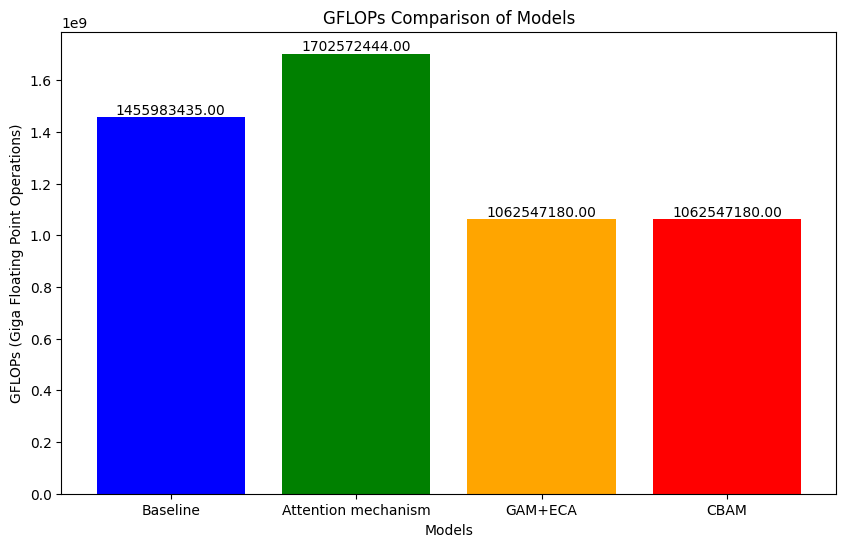

In [45]:
import matplotlib.pyplot as plt

models = ['Baseline', 'Attention mechanism', 'GAM+ECA', 'CBAM']
flops = [flops_baseline, flops_att, flops_gam_eca, flops_cbam]

plt.figure(figsize=(10,6))
bars = plt.bar(models, flops, color=['blue', 'green', 'orange', 'red'])
plt.title('GFLOPs Comparison of Models')
plt.ylabel('GFLOPs (Giga Floating Point Operations)')
plt.xlabel('Models')

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{yval:.2f}', ha='center', va='bottom')

plt.show()
